 ## Introduciton
This IPython Notebook is designed to compare the performance of two ways of training a Gaussian mixture model: 1) EM (as everyone will think of) and 2) maximize the loglikelihood by SGD. The latter has been investigated by David Rosenberg: https://davidrosenberg.github.io/mlcourse/Archive/2017/Lectures/13.lab.mixture-models.pdf 

This code handles a mixture of M Gaussian distributions, each of which has D dimensions. 

In our experiments, we set M=3 and D=2. We implement the EM and SGD using PyTorch and visualize the results. 
According to Rosenberg, in this simple case, EM and SGD should perform similarly, but that is not what we observed. So we would like to investigate the reason. 


## Preparing data
First we import necessary libraries, including Numpy(1.16.4), PyTorch(1.1.0), Matplotlib(3.1.0) and set some parameters used in the model, including data dimension, how many components in the mixture model and the dataset size. In this example, we use 2-d data and a 3-component Gaussian mixture model with 20000 data points.

In [0]:
import pickle
import time
import os
import numpy as np
import torch
import pylab
import matplotlib.pyplot as plt
np.random.seed(12345)
torch.manual_seed(12345)
# Data dimension
d = 2
# Gaussian mixture model components number
k = 3
# datset size
N = 20000


Here, we manually set the ground truth of weights of components, mean values and covariance matrices. To give a clear visual effect, we make three components as distinguishable as possible.


In [0]:
true_pis = [0.3, 0.4, 0.3]
true_mus = [np.array([2.0, 2.0]).reshape(d, 1), 
            np.array([0.0, -2.0]).reshape(d, 1),
            np.array([-2.5, 1.0]).reshape(d, 1)]
true_covs = [np.identity(d).reshape(d, d),
             np.array([[0.5, -0.3], [-0.3, 0.5]]).reshape(d, d),
             np.array([[0.6, 0.4], [0.4, 0.6]]).reshape(d, d)]

The following function using standard sample method to sample from a Gaussian mixture model. We first randomly pick the individual Gaussian component based on their weights, then use Numpy to sample from a multivariate Gaussian function. 

In [0]:
def sample(pis, mus, covs, sample_num=1):
    """ This is sample frunction for gaussian mixture model given wegihts, means
    and covariance matrices of all components.
    Arguments:
        pis: all weights, a list of float, sum to 1
        mus: mean values, a list of numpy d*1 array
        covs: covariance matrices, a list of numpy d*d array
    Return:
        samples: total 'sample_num' samples, a sample_num*d*1 np array.
    """
    assert(len(pis)==len(mus) and len(pis) == len(covs)), 'Components not match'
    assert(sum(pis) == 1), 'Components weights should sum to 1'
    for mu, cov in zip(mus, covs):
        assert(mu.shape[1] == 1)
        assert(mu.shape[0] >= mu.shape[1]), 'mu must be a column vector'
        assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
        assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the \
        same dimensions'
    
    k_choices = np.random.choice(len(pis), sample_num, p=pis)
    samples = np.stack([np.random.multivariate_normal(mus[i].squeeze(axis=-1),\
                        covs[i]).reshape(d,1) for i in k_choices], axis=0)
    return samples


In [0]:
def multivariate_gaussian(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)

    Arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
    '''
    assert(mu.shape[0] >= mu.shape[1]), 'mu must be a row vector'
    assert(x.shape[0] >= x.shape[1]), 'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the same\
    dimensions'
    assert(mu.shape[0] == x.shape[0]), 'mu and x must have the same dimensions'
    dim = mu.shape[0]
    part1 = 1 / (((2* np.pi)**(len(mu)/2)) * (np.linalg.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).T.dot(np.linalg.inv(cov))).dot((x-mu))

    return float(part1 * np.exp(part2))

In [0]:
samples = sample(true_pis, true_mus, true_covs, sample_num=N)

Let's have a look at the sampled data.

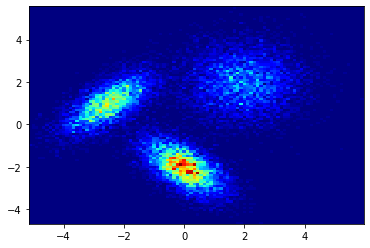

In [0]:
plt.hist2d(np.squeeze(samples[:,0, :]), np.squeeze(samples[:,1,:]), \
           bins=(100, 100), cmap=plt.cm.jet)
plt.show()

To have a reference, let's look at what the actual function looks like. 

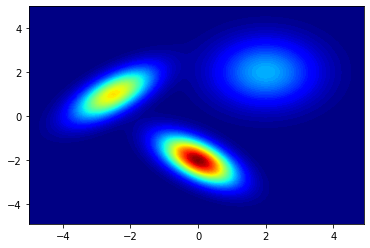

In [0]:
# True function 
x = np.arange(-5.0, 5.0, 0.1)
y = np.arange(5.0, -5.0, -0.1)
X, Y = np.meshgrid(x, y)
grid = np.stack([X, Y], axis=-1).reshape(10000, 2, 1)

true_prob = np.array([sum([pi * multivariate_gaussian(x, mu, cov) for pi, mu,\
                     cov in zip(true_pis, true_mus, true_covs)]) for x in grid])
plt.contourf(X, Y, true_prob.reshape(100,100), 100, cmap=plt.cm.jet)


Now, we split the data with ratio 8:1:1 to train, develop and test set and calculate the ground truth log likelihood per sample on each dataset. 

In [0]:
def getLoglikelihood(data, pi, mu, cov):
    loglikelihood = sum([np.log(sum([pi[i]*multivariate_gaussian(x, mu[i], \
                         cov[i]) for i in range(len(pi))])) for x in data]) \
                    / len(data)
    return loglikelihood

In [0]:
# Data split
train_data = samples[:int(N*0.8)]
dev_data = samples[int(N*0.8):int(N*0.9)]
test_data = samples[int(N*0.9):]

true_train_loglikelihood = getLoglikelihood(train_data, true_pis, true_mus, true_covs)
true_dev_loglikelihood = getLoglikelihood(dev_data, true_pis, true_mus, true_covs)
true_test_loglikelihood = getLoglikelihood(test_data, true_pis, true_mus, true_covs)

print('Train data log likelihood: {:.4f}'.format(true_train_loglikelihood))
print('Dev data log likelihood: {:.4f}'.format(true_dev_loglikelihood))
print('Test data log likelihood: {:.4f}'.format(true_test_loglikelihood ))

Train data log likelihood: -3.3159
Dev data log likelihood: -3.2921
Test data log likelihood: -3.3132


## Gaussian Mixture

Let $\mathbf{x} = (\mathbf{x}_1, \mathbf{x}_2, ..., \mathbf{x}_N)$ be a sample of n independent observations from a mixture of $K$ multivariate normal distributions of dimension $D$, and let $\mathbf{z} = (z_1, z_2, ..., z_N) $ be the latent variables that determine the component from which the observation originates. That is,

$$X_n \mid(Z_n= k) \sim \mathcal{N}_D(\boldsymbol{\mu}_k, \Sigma_k) $$
$$P(Z_n = k) = \tau_k$$
where $\sum_{k=1}^{K} \tau_k = 1$

Our goal here is to estimate the unknown parameters representing the mixing value between Gaussians and the means and covariances of each:
$$\boldsymbol{\theta} = (\theta_1, \theta_2, ..., \theta_K), \text{where }\theta_k = (\tau_k, \boldsymbol{\mu}_k, \Sigma_k)$$

Therefore, the joint probability of observed samples and hidden variables, according to Bayes theorem, should be:

$$p(\mathbf{x}, \mathbf{z} \mid \boldsymbol{\theta}) = \prod_{n=1}^{N}\prod_{k=1}^{K}[\tau_k \cdot g(\mathbf{x}_n; \boldsymbol{\mu}_k, \Sigma_k)]^{\mathbb{I}(z_n = k)}$$

where $\mathbb{I}$ is the indicator function and $g$ is the probability density function of a multivariate normal distribution. Then, the complete data log likelihood function should be 

$$
\begin{align*}
\log{L(\boldsymbol{\theta}; \mathbf{x, z})} &= \log p(\mathbf{x}, \mathbf{z} \mid \boldsymbol{\theta}) \\
&= \sum_{n=1}^{N}\sum_{k=1}^{K} \mathbb{I}(z_n = k)[\log \tau_k - \frac{1}{2}\log{\mid \Sigma_k\mid} - \frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\mathsf{T}\Sigma_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) - \frac{D}{2}\log{2\pi}]
\end{align*}
$$

 ## EM algorithm

In E step, we calculate the posterior probabilities for each components given the samples.
$$
\gamma_{k;n}^{(t)} 
:= P(Z_n=k\mid X_n = \mathbf{x}_n; \boldsymbol{\theta}^{(t)}) = \dfrac{\tau_{k}^{(t)}\cdot g(\mathbf{x}_n; \boldsymbol{\mu}_k^{(t)}, \Sigma_{k}^{(t)})}{\sum_{l=1}^{K}\tau_{l}^{(t)}\cdot g(\mathbf{x}_n; \boldsymbol{\mu}_l^{(t)}, \Sigma_{l}^{(t)})}
$$

The expectation data-dependent log likelihood hereby is given by the following formula
$$
\begin{align*}
Q(\boldsymbol{\theta}\mid\boldsymbol{\theta}^{(t)}) &= \mathbb{E}_{\mathbf{Z}\mid\mathbf{X}, \boldsymbol\theta^{(t)}}[\log{L(\boldsymbol\theta; \mathbf{x}, \mathbf{Z})}] \\
&= \sum_{n=1}^{N}\sum_{k=1}^{K} \gamma_{k,n}^{(t)}[\log \tau_k - \frac{1}{2}\log{\mid \Sigma_k\mid} - \frac{1}{2}(\mathbf{x}_n - \boldsymbol{\mu}_k)^\mathsf{T}\Sigma_k^{-1}(\mathbf{x}_n - \boldsymbol{\mu}_k) - \frac{D}{2}\log{2\pi}]
\end{align*}
$$

In [0]:
# E step
def Estep(dataset, pi_t, mu_t, cov_t):
    k = len(pi_t)
    gammas = []
    expectation_loglikelihood = 0.0 
    for x in dataset:
        gamma_raw = [pi_t[i] * multivariate_gaussian(x, mu_t[i],\
                     cov_t[i]) for i in range(k)]
        gamma = [g / sum(gamma_raw) for g in gamma_raw]
        gammas.append(gamma)
    
        expectation_loglikelihood += sum([gamma[k] * np.log(pi_t[k] * \
                                          multivariate_gaussian(x, mu_t[k], \
                                          cov_t[k])) for k in range(len(pi_t))])
    
    return np.array(gammas), expectation_loglikelihood / len(dataset)


In M step, we pick $\theta^{(t+1)}$ that maximizes $Q(\boldsymbol{\theta}\mid\boldsymbol{\theta}^{(t)})$, that is
$$\boldsymbol\tau^{(t+1)} = \operatorname*{argmax}_\boldsymbol{\tau^{(t)}} Q(\boldsymbol{\theta}\mid\boldsymbol{\theta}^{(t)})$$
$$
(\boldsymbol\mu^{(t+1)}_k, \Sigma_k^{(t+1)}) = \operatorname*{argmax}_{(\boldsymbol\mu^{(t)}_k, \Sigma_k^{(t)})}Q(\boldsymbol{\theta}\mid\boldsymbol{\theta}^{(t)})
$$

Therefore, we could use following formula to update parameters.
$$\tau_k^{(t+1)} = \dfrac{\sum_{n=1}^{N} \gamma_{k;n}^{(t)}}{\sum_{n=1}^{N}\sum_{k=1}^{K} \gamma_{k;n}^{(t)}} = \frac{1}{N}\sum_{n=1}^{N}\gamma_{k,n}^{(t)}$$

$$\boldsymbol\mu_k^{(t+1)} = \dfrac{\sum_{n=1}^{N} \gamma_{k;n}^{(t)}\mathbf{x}_n}{\sum_{n=1}^{N} \gamma_{k;n}^{(t)}}$$

$$\Sigma_k^{(t+1)} = \dfrac{\sum_{n=1}^{N} \gamma_{k;n}^{(t)}(\mathbf{x}_n - \boldsymbol\mu_k^{(t+1)})(\mathbf{x}_n - \boldsymbol\mu_k^{(t+1)})^\mathsf{T}}{\sum_{n=1}^{N} \gamma_{k;n}^{(t)}}$$

In [0]:
# M step
def Mstep(dataset, gammas):
    pi_t, mu_t, cov_t = [], [], []
    gamma_k = np.sum(gammas, axis=0)

    pi_t = gamma_k / len(dataset)
    mu_t = [sum([gammas[i][k]*x for i, x in enumerate(dataset)])/gamma_k[k] for k in range(len(pi_t))]
    cov_t = [sum([gammas[i][k]*(x-mu_t[k]).dot((x-mu_t[k]).T) for i, x in enumerate(dataset)])/gamma_k[k] for k in range(len(pi_t))]


    return pi_t, mu_t, cov_t


We terminate the algorithm when $Q(\boldsymbol{\theta}\mid\boldsymbol{\theta}^{(t)})$ changes smaller than the given threshold $\epsilon=10^{-4}$

In [0]:
# EM
def EMAlgorithm(train_data):
    mu = np.random.uniform(size=(k, d, 1))
    cov = np.array([np.identity(d) for i in range(k)])
    pi = [1/len(mu) for i in range(len(mu))]
    
    best_loglikelihood = -np.infty
    last_loglikelihood = -np.infty
    best_pi = None
    best_mu = None
    best_cov = None

    while True:
        gammas, loglikelihood = Estep(train_data, pi, mu, cov)
        pi, mu, cov = Mstep(train_data, gammas)
        
        if loglikelihood > best_loglikelihood:
            best_loglikelihood = loglikelihood.copy()
            best_pi = pi
            best_mu = mu
            best_cov = cov
        if np.abs(loglikelihood - last_loglikelihood) <= 1e-4:
            break
        last_loglikelihood = loglikelihood
#         print('Current loglik: {:.4f}\nBest    loglik: {:.4f}'.format(float(loglikelihood), float(best_loglikelihood)))
    
    return best_pi, best_mu, best_cov


We now run the algorithm, show the final estimated model and calculate the log likelihood on each dataset.

In [0]:
tic = time.time()
em_pis, em_mus, em_covs = EMAlgorithm(train_data)
toc = time.time()
print('Finished in {:.2f}s'.format(toc-tic))
function_formula = ''
for i in range(k):
    if i != 0:
        function_formula += ' + \n'
    function_formula += '{:.4f}*N({}, {})'.format(em_pis[i], np.around(em_mus[i],decimals=4).reshape(d,).tolist(), np.around(em_covs[i],decimals=4).reshape(d,d).tolist())
print('Best Estimate:\t{}'.format(function_formula))


Finished in 92.71s
Best Estimate:	0.3059*N([-2.4878, 1.0133], [[0.6055, 0.3977], [0.3977, 0.5952]]) + 
0.2984*N([1.9789, 2.0205], [[0.9917, -0.0025], [-0.0025, 0.9647]]) + 
0.3957*N([-0.0018, -1.9918], [[0.5035, -0.305], [-0.305, 0.5278]])


In [0]:
em_train_loglikelihood = getLoglikelihood(train_data, em_pis, em_mus, em_covs)
em_dev_loglikelihood = getLoglikelihood(dev_data, em_pis, em_mus, em_covs)
em_test_loglikelihood = getLoglikelihood(test_data, em_pis, em_mus, em_covs)
print('Estimated train data log likelihood: {:.4f}'.format(em_train_loglikelihood))
print('Estimated dev data log likelihood: {:.4f}'.format(em_dev_loglikelihood))
print('Estimated test data log likelihood: {:.4f}'.format(em_test_loglikelihood))

Estimated train data log likelihood: -3.3150
Estimated dev data log likelihood: -3.2926
Estimated test data log likelihood: -3.3142


Now let's have a look at the estimated model given by EM algorithm. Pretty awesome, right?

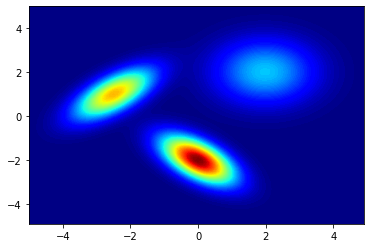

In [0]:
em_prob = np.array([sum([pi * multivariate_gaussian(x, mu, cov) for pi, mu, cov in zip(em_pis, em_mus, em_covs)]) for x in grid])
plt.contourf(X, Y, em_prob.reshape(100,100), 100, cmap=plt.cm.jet)

 ## SGD

In this section, instead of using EM algorithm, we directly train the complete data joint loglikelihood to see if we could get a as good or better result. We use the SGD optimizer provided by PyTorch.

We need to rewrite some functions in PyTorch to pass the gradients.

In [0]:
def torch_multivariate_gaussian(x, mu, cov):
    '''
    Caculate the multivariate normal density (pdf)

    Arguments:
        x = numpy array of a "d x 1" sample vector
        mu = numpy array of a "d x 1" mean vector
        cov = "numpy array of a d x d" covariance matrix
    '''
    assert(mu.shape[0] >= mu.shape[1]), 'mu must be a row vector'
    assert(x.shape[0] >= x.shape[1]), 'x must be a row vector'
    assert(cov.shape[0] == cov.shape[1]), 'covariance matrix must be square'
    assert(mu.shape[0] == cov.shape[0]), 'cov_mat and mu_vec must have the same dimensions'
    assert(mu.shape[0] == x.shape[0]), 'mu and x must have the same dimensions'
    dim = mu.shape[0]
    part1 = 1 / ( ((2* np.pi)**(len(mu)/2)) * (torch.det(cov)**(1/2)) )
    part2 = (-1/2) * ((x-mu).transpose(-1,-2).matmul(torch.inverse(cov))).matmul((x-mu))
    return part1 * torch.exp(part2)

def torch_getLoglikelihood(data, pi, mu, cov):
    loglikelihood = sum([torch.log(torch.sum(torch.stack([pi[i]*torch_multivariate_gaussian(x, mu[i], cov[i]) for i in range(len(pi))], dim=0))) for x in data]) / len(data)
    return loglikelihood

In [0]:
def sgd(train_data, dev_data, batch_size=16, max_epoch=10, log_freq=32):
    train_data = torch.from_numpy(train_data)
    dev_data = torch.from_numpy(dev_data)

    sgd_mu = torch.nn.Parameter(torch.from_numpy(np.random.uniform(size=(k, d, 1))))
    sgd_cov = torch.nn.Parameter(torch.from_numpy(np.array([np.identity(d) for i in range(k)])))
    sgd_pi = torch.nn.Parameter(torch.from_numpy(np.array([1/len(sgd_mu) for i in range(len(sgd_mu))])))

    optim = torch.optim.SGD([sgd_pi, sgd_mu, sgd_cov], lr=0.0001)

    train_size = len(train_data)
    episode = 0
    current_batch = []
    best_loglikelihood = -torch.tensor(np.infty).double()
    last_dev_loglikelihood = -torch.tensor(np.infty).double()
    while episode < max_epoch * train_size:
        current_batch.append(train_data[episode%train_size])
        if len(current_batch) % batch_size == 0:
            optim.zero_grad()
            current_batch = torch.stack(current_batch, dim=0)
            pi_normal = sgd_pi / torch.sum(sgd_pi)
            loss = -torch_getLoglikelihood(current_batch, pi_normal, sgd_mu, sgd_cov)
            loss.backward()
            optim.step()
            current_batch = []
        if episode % log_freq == log_freq-1:
            pi_normal = sgd_pi / torch.sum(sgd_pi)
            dev_loglikelihood = torch_getLoglikelihood(dev_data, pi_normal, sgd_mu, sgd_cov)
            if dev_loglikelihood > best_loglikelihood:
                best_loglikelihood = dev_loglikelihood
                best_pi = pi_normal.clone()
                best_mu = sgd_mu.clone()
                best_cov = sgd_cov.clone()
            if torch.abs(dev_loglikelihood-last_dev_loglikelihood) < 1e-6:
                print('break')
                break
            last_dev_loglikelihood = dev_loglikelihood
            
            print('Current lik: {:.4f}, Best lik: {:.4f}'.format(dev_loglikelihood.item(), best_loglikelihood.item())) 
        episode += 1
         
    return best_pi, best_mu, best_cov


In [0]:
tic = time.time()
sgd_pis, sgd_mus, sgd_covs = sgd(train_data, dev_data, batch_size=50, max_epoch=1, log_freq=100)
toc = time.time()
function_formula = ''
for i in range(k):
    if i != 0:
        function_formula += ' + \n'
    function_formula += '{:.4f}*N({}, {})'.format(sgd_pis[i].item(), sgd_mus[i].tolist(), sgd_covs[i].tolist())
print('Best Estimate\t{}'.format(function_formula))

Current lik: -5.9319, Best lik: -5.9319
Current lik: -5.9314, Best lik: -5.9314
Current lik: -5.9309, Best lik: -5.9309
Current lik: -5.9304, Best lik: -5.9304
Current lik: -5.9299, Best lik: -5.9299
Current lik: -5.9295, Best lik: -5.9295
Current lik: -5.9291, Best lik: -5.9291
Current lik: -5.9286, Best lik: -5.9286
Current lik: -5.9281, Best lik: -5.9281
Current lik: -5.9276, Best lik: -5.9276
Current lik: -5.9271, Best lik: -5.9271
Current lik: -5.9266, Best lik: -5.9266
Current lik: -5.9262, Best lik: -5.9262
Current lik: -5.9257, Best lik: -5.9257
Current lik: -5.9253, Best lik: -5.9253
Current lik: -5.9248, Best lik: -5.9248
Current lik: -5.9243, Best lik: -5.9243
Current lik: -5.9239, Best lik: -5.9239
Current lik: -5.9235, Best lik: -5.9235
Current lik: -5.9230, Best lik: -5.9230
Current lik: -5.9224, Best lik: -5.9224
Current lik: -5.9219, Best lik: -5.9219
Current lik: -5.9215, Best lik: -5.9215
Current lik: -5.9210, Best lik: -5.9210
Current lik: -5.9205, Best lik: -5.9205


In [0]:
sgd_train_loglikelihood = torch_getLoglikelihood(torch.from_numpy(train_data), sgd_pis, sgd_mus, sgd_covs).item()
sgd_dev_loglikelihood = torch_getLoglikelihood(torch.from_numpy(dev_data), sgd_pis, sgd_mus, sgd_covs).item()
sgd_test_loglikelihood = torch_getLoglikelihood(torch.from_numpy(test_data), sgd_pis, sgd_mus, sgd_covs).item()
print('Estimated train data log likelihood: {:.4f}'.format(sgd_train_loglikelihood))
print('Estimated dev data log likelihood: {:.4f}'.format(sgd_dev_loglikelihood))
print('Estimated test data log likelihood: {:.4f}'.format(sgd_test_loglikelihood))

Estimated train data log likelihood: -5.8502
Estimated dev data log likelihood: -5.8596
Estimated test data log likelihood: -5.7937


Now let's have a look at what SGD gives us.

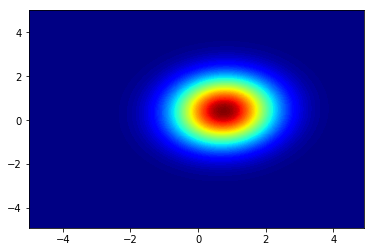

In [0]:
sgd_prob = np.array([sum([pi * multivariate_gaussian(x, mu, cov) for pi, mu, cov in zip(sgd_pis.detach().numpy(), sgd_mus.detach().numpy(), sgd_covs.detach().numpy())]) for x in grid])
plt.contourf(X, Y, sgd_prob.reshape(100,100), 100, cmap=plt.cm.jet)

Tha's what we really expected. What's going wrong here?

## Comparison

Now let's have a more direct view on what we've got.


In [0]:
def form_formula(pis, mus, covs, torch=False):
  function_formula = ''
  if torch:
      pis = pis.detach().numpy()
      mus = mus.detach().numpy()
      covs = covs.detach().numpy()
  for i in range(k):
      if i != 0:
          function_formula += ' + \n'
      
      function_formula += '{:.4f}*N({}, {})'.format(pis[i], np.around(mus[i],decimals=4).reshape(d,).tolist(), np.around(covs[i],decimals=4).reshape(d,d).tolist())
  return function_formula
# print(type(sgd_pis.detach().numpy()))
true_model = form_formula(true_pis, true_mus, true_covs)
em_model = form_formula(em_pis, em_mus, em_covs)
sgd_model = form_formula(sgd_pis, sgd_mus, sgd_covs, torch=True)
print('Ground Truth:\n{}\nEM Algorithm:\n{}\nSGD:\n{}'.format(true_model, em_model, sgd_model))

Ground Truth:
0.3000*N([2.0, 2.0], [[1.0, 0.0], [0.0, 1.0]]) + 
0.4000*N([0.0, -2.0], [[0.5, -0.3], [-0.3, 0.5]]) + 
0.3000*N([-2.5, 1.0], [[0.6, 0.4], [0.4, 0.6]])
EM Algorithm:
0.2961*N([2.0348, 1.9703], [[0.9956, -0.0105], [-0.0105, 1.0081]]) + 
0.4020*N([-0.0072, -2.0019], [[0.5027, -0.3025], [-0.3025, 0.5057]]) + 
0.3019*N([-2.4986, 1.0014], [[0.5824, 0.3943], [0.3943, 0.5983]])
SGD:
0.3445*N([0.5786, 0.0387], [[1.0224, 0.0007], [0.0007, 1.0186]]) + 
0.3280*N([0.8919, 0.7329], [[1.0153, 0.0038], [0.0038, 1.0086]]) + 
0.3276*N([0.8112, 0.5002], [[1.016, 0.0027], [0.0027, 1.0099]])


Here comes the loglikelihood comparison

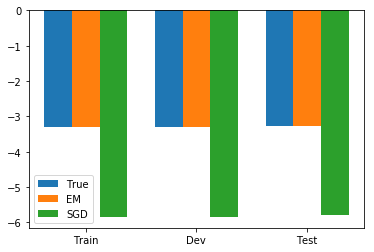

In [0]:
bar_width = 0.25

r1 = np.arange(3)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

x_name = ['train', 'dev', 'test']
true_loglikelihood = [true_train_loglikelihood, true_dev_loglikelihood, true_test_loglikelihood]
em_loglikelihood = [em_train_loglikelihood, em_dev_loglikelihood, em_test_loglikelihood]
sgd_loglikelihood = [sgd_train_loglikelihood, sgd_dev_loglikelihood, sgd_test_loglikelihood]

plt.bar(r1, true_loglikelihood, width=bar_width, label='True')
plt.bar(r2, em_loglikelihood, width=bar_width, label='EM')
plt.bar(r3, sgd_loglikelihood, width=bar_width, label='SGD')

plt.xticks([r + bar_width for r in range(3)], ['Train', 'Dev', 'Test'])
plt.legend()

